In [1]:
import pandas as pd
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
! pwd

/home/jupyter/tutorials/fastai/course-v3/nbs/dl1


In [4]:
path = untar_data(URLs.FOOD)

In [5]:
bs = 64

In [6]:
len((path/'images/').ls())

104

In [7]:
df_train=pd.read_json(path/"train.json")
train_list=pd.DataFrame(df_train.values.flatten())
train_list["is_valid"]=False
train_list["label"]=train_list.iloc[:,0].str.split('/',expand=True)[0]
train_list.columns.values[0]="fname"


In [8]:
df_test=pd.read_json(path/"test.json")
test_list=pd.DataFrame(df_test.values.flatten())
test_list["is_valid"]=True
test_list["label"]=test_list.iloc[:,0].str.split('/',expand=True)[0]
test_list.columns.values[0]="fname"


In [9]:
train_list.head()

fname  is_valid              label
0            churros/1004234     False            churros
1  hot_and_sour_soup/1002782     False  hot_and_sour_soup
2             samosa/1008131     False             samosa
3            sashimi/1001239     False            sashimi
4          pork_chop/1000802     False          pork_chop

In [10]:
test_list.head()

fname  is_valid              label
0            churros/1061830      True            churros
1  hot_and_sour_soup/1000486      True  hot_and_sour_soup
2             samosa/1009326      True             samosa
3             sashimi/100113      True            sashimi
4          pork_chop/1012227      True          pork_chop

In [11]:
split_list=train_list.append(test_list)

In [12]:
src=(ImageList.from_df(split_list,path/'images',suffix='.jpg')
     .split_from_df(1)
     .label_from_df(cols="label"))

In [13]:
ds_tfms = ([RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-40.0, 40.0)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.34, 0.65)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.43)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmAffine (squish), kwargs={'scale':(.42,2.4)}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude':(-0.02,0.02)}, p=0.5, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (skew), kwargs={'direction': (0.0, 7), 'magnitude':(0.2)}, p=0.5, resolved={}, do_run=True, is_random=True)],
           [])

In [14]:
def get_data(size, bs):
    return (src
           .transform(ds_tfms, size=size)
           .databunch(bs=bs).normalize(imagenet_stats))

In [15]:
data = get_data(192, bs=64)

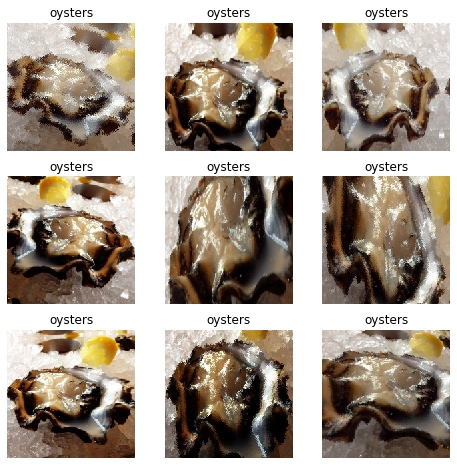

In [16]:
def _plot(i,j,ax):
    x,y = data.train_ds[100]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

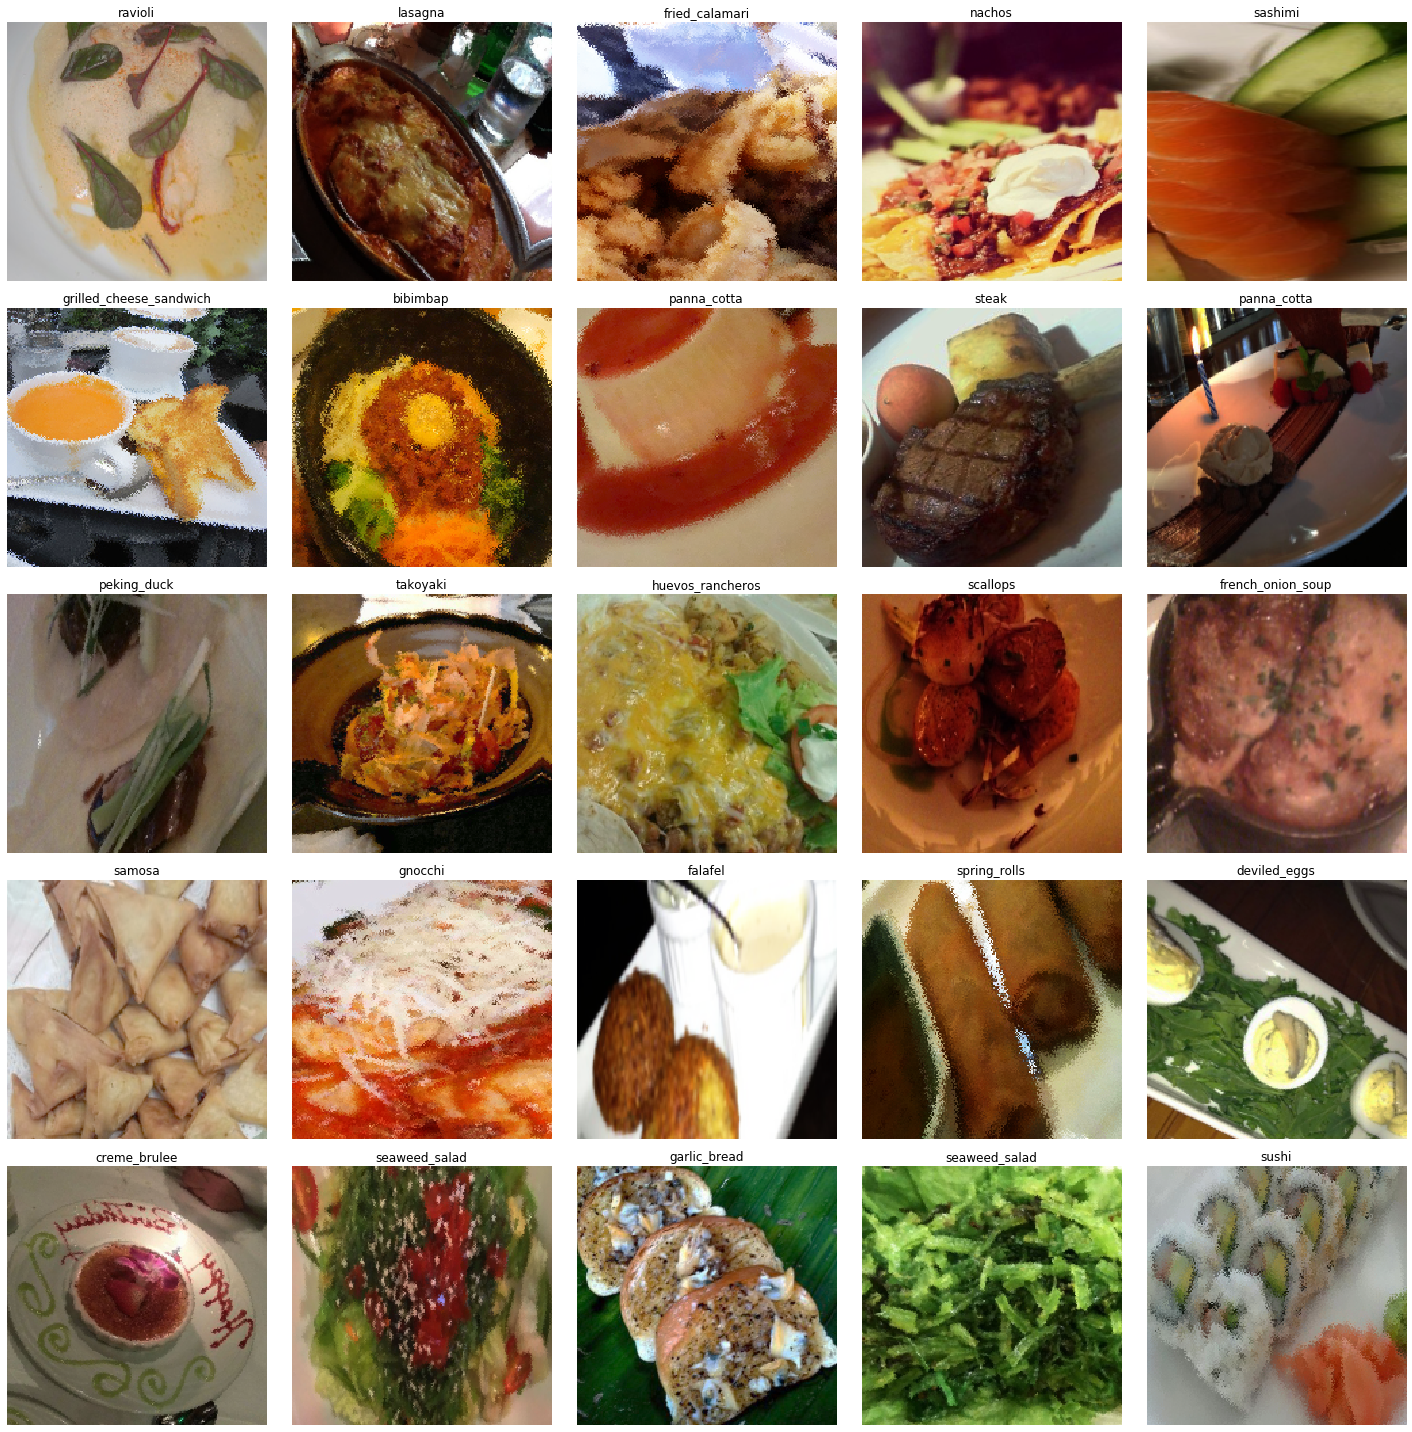

In [16]:
data.show_batch()

In [54]:
data = get_data(192, bs=64)

In [41]:
'''
learn.export('trained_model.pkl')
path2=learn.path
learn = load_learner(path2,'trained_model.pkl')
'''

"\nlearn.export('trained_model.pkl')\npath2=learn.path\nlearn = load_learner(path2,'trained_model.pkl')\n"

In [15]:
learn = cnn_learner(data, models.resnet50,pretrained=True, metrics=[accuracy, top_k_accuracy], callback_fns=ShowGraph).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


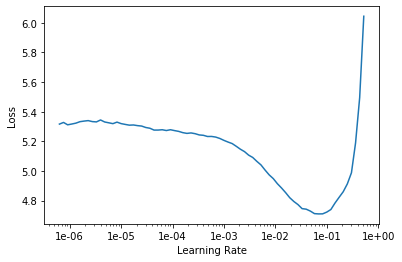

In [46]:
learn.lr_find()
learn.recorder.plot(suggestions=True)

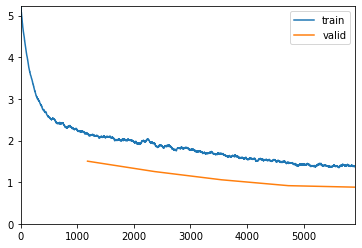

In [47]:
lr=1e-02
learn.fit_one_cycle(5,slice(lr))

In [48]:
learn.save('food-101-ResNet50-stage1')
learn.load('food-101-ResNet50-stage1')


Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


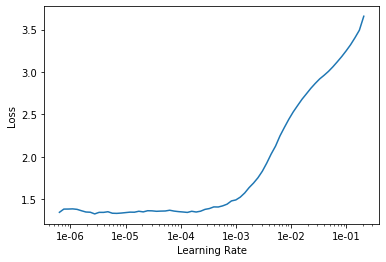

In [49]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestions=True)

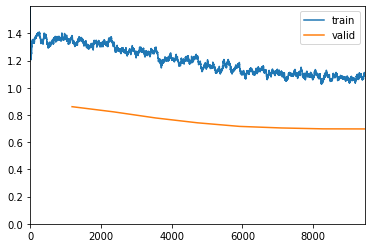

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [50]:
learn.fit_one_cycle(8, max_lr=slice(1e-06,1e-04))

In [51]:
learn.save('food-101-ResNet50-stage2')



In [16]:
learn.load('food-101-ResNet50-stage2')

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


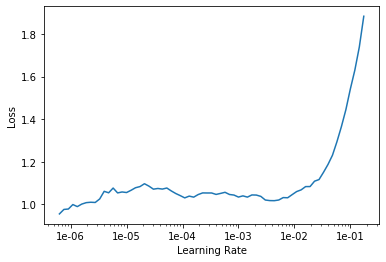

In [17]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-06,1e-03))

In [ ]:
learn.save('food-101-ResNet50-stage3')



In [17]:
data = get_data(384, bs=48)

In [48]:
learn = cnn_learner(data, models.resnet50,pretrained=True,
                    metrics=[accuracy, top_k_accuracy], callback_fns=ShowGraph).to_fp16()

In [49]:
learn.load('food-101-ResNet50-stage3')

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

In [50]:
learn.purge()

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

In [43]:
learn.validate(data.valid_dl,metrics=[accuracy,top_k_accuracy])

[1.0558531, tensor(0.7216), tensor(0.9113)]

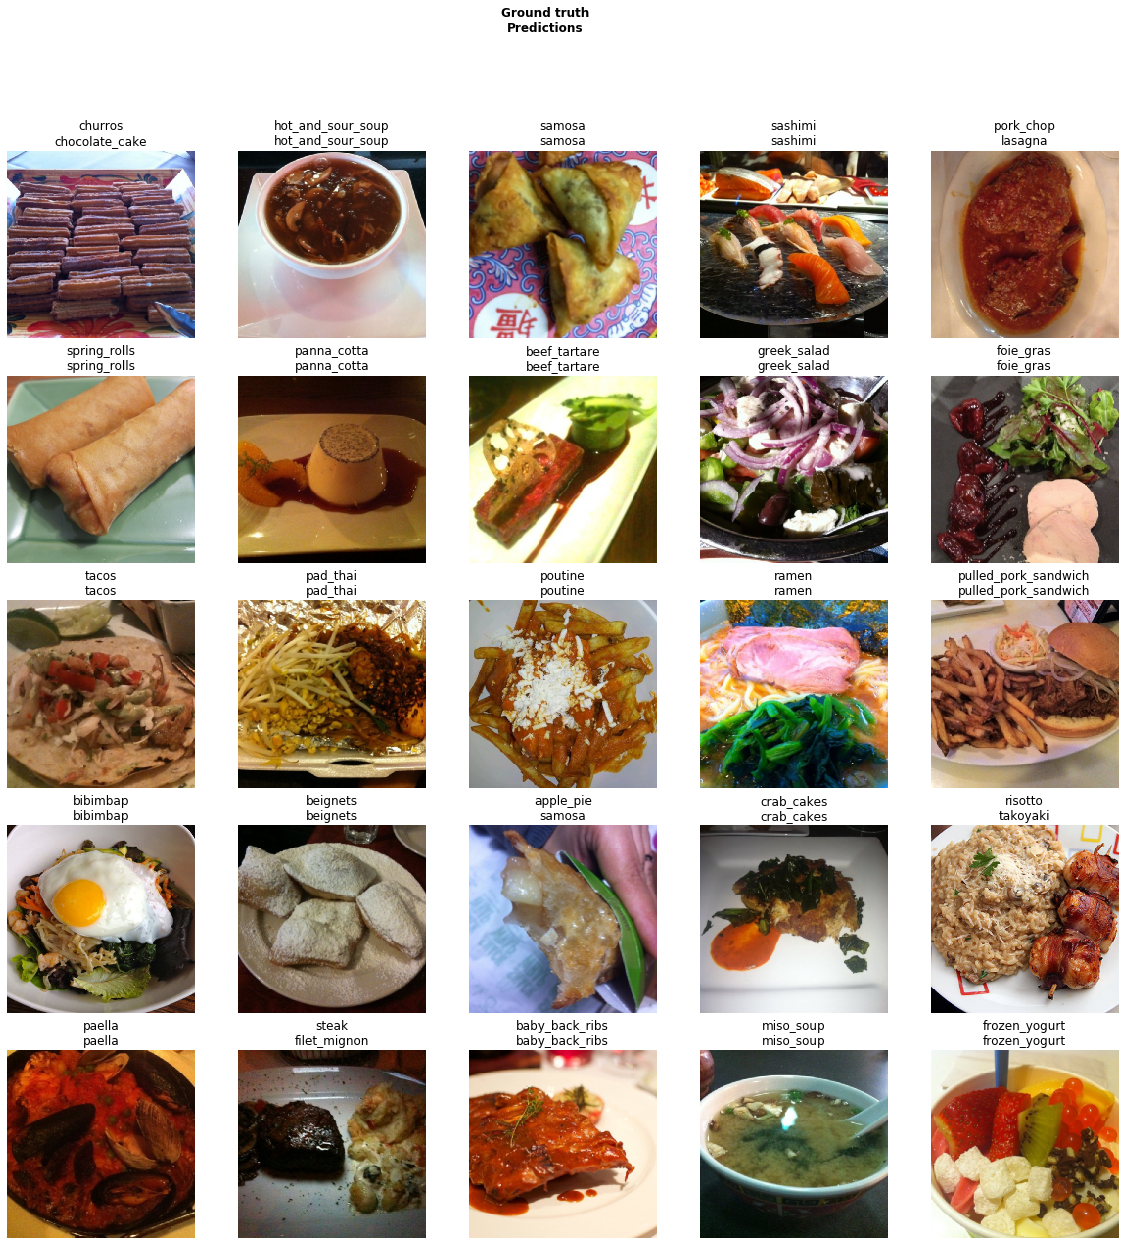

In [34]:
learn.show_results()

In [51]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


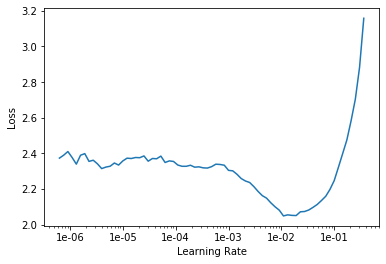

In [52]:
learn.lr_find()
learn.recorder.plot()

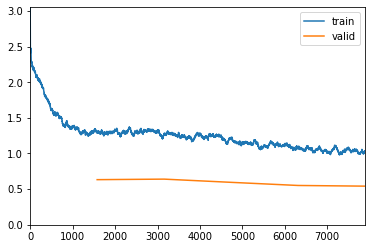

In [53]:
lr=1e-02/2
learn.fit_one_cycle(5, slice(lr))

In [54]:
learn.save('food-101-ResNet50-stage4')

In [61]:
learn.load('food-101-ResNet50-stage4')

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

In [14]:
data = get_data(384, bs=48)

In [15]:
learn = cnn_learner(data, models.resnet50,
                    metrics=[accuracy, top_k_accuracy], callback_fns=ShowGraph).to_fp16()

In [16]:
learn.load('food-101-ResNet50-stage4')

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

In [17]:
learn.purge()

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

In [18]:
gc.collect()

20

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


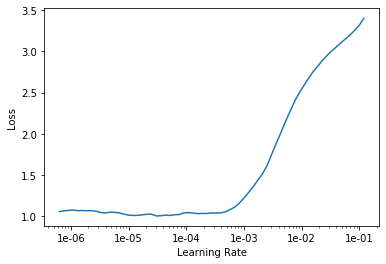

In [20]:
learn.lr_find()
learn.recorder.plot()

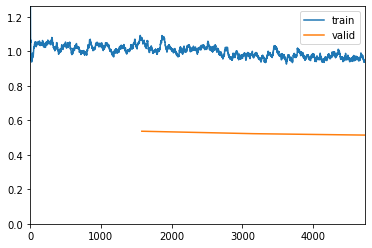

In [21]:

learn.fit_one_cycle(3, max_lr=slice(1e-06,1e-04/2))

In [22]:
learn.save('food-101-ResNet50-stage5')



In [23]:
learn.load("food-101-ResNet50-stage5")

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

In [15]:
data = get_data(512, bs=48)


In [15]:
data = get_data(512, bs=48)

learn = cnn_learner(data, models.resnet50,
                    metrics=[accuracy, top_k_accuracy], callback_fns=ShowGraph)

In [24]:
learn.purge()
gc.collect()

0

In [17]:
learn.load("food-101-ResNet50-stage5")

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

In [16]:
learn.freeze()

In [17]:
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


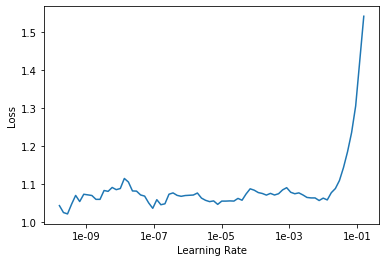

In [20]:
learn.lr_find(start_lr=1e-11)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


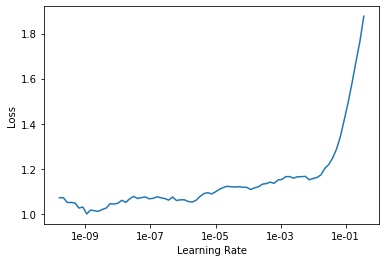

In [21]:
learn.lr_find(start_lr=1e-11,wd=0.9)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


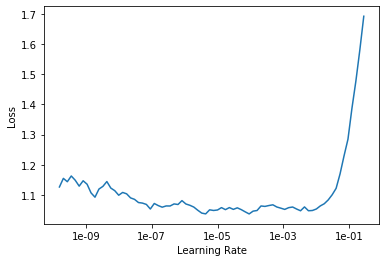

In [22]:
learn.lr_find(start_lr=1e-11,wd=0.5)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


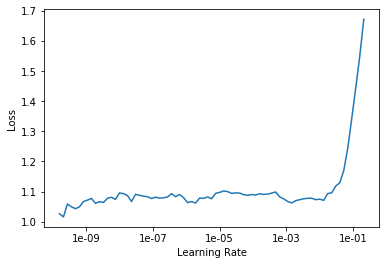

In [23]:
learn.lr_find(start_lr=1e-11,wd=0.1)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


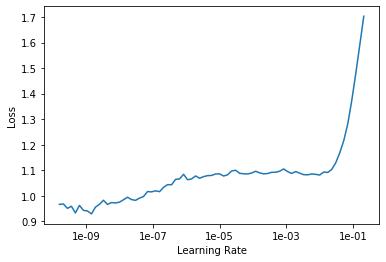

In [24]:
learn.lr_find(start_lr=1e-11,wd=0.01)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


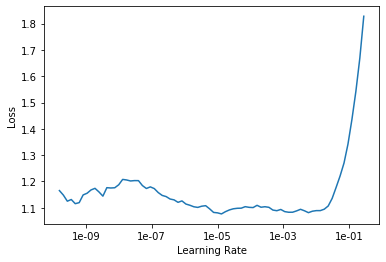

In [25]:
learn.lr_find(start_lr=1e-11,wd=0.09)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


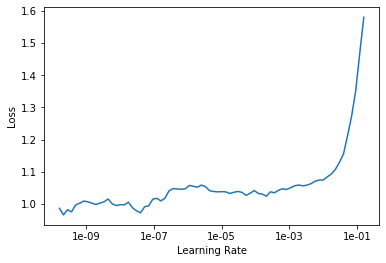

In [27]:
learn.lr_find(start_lr=1e-11,wd=0.08)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


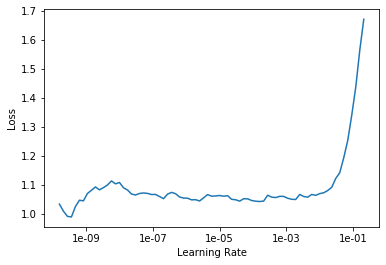

In [28]:
learn.lr_find(start_lr=1e-11,wd=0.095)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


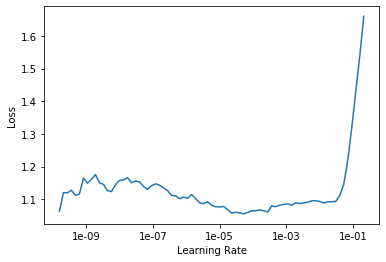

In [29]:
learn.lr_find(start_lr=1e-11,wd=0.001)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


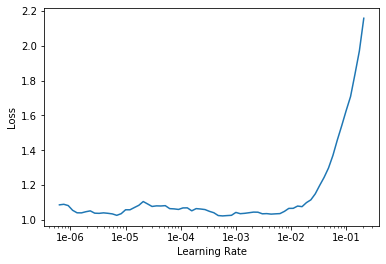

In [30]:
learn.lr_find(wd=0.002)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


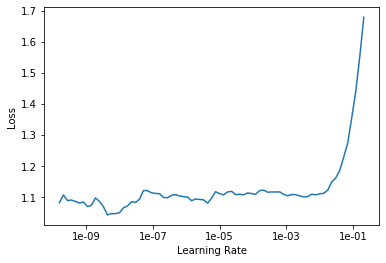

In [26]:
learn.lr_find(start_lr=1e-11,wd=0.005)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


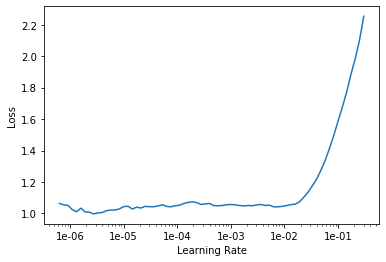

In [31]:
learn.lr_find(wd=0.5)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


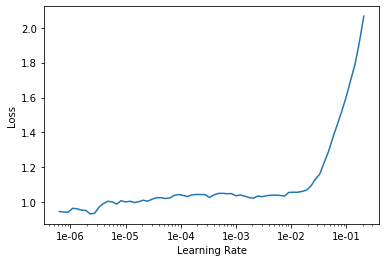

In [32]:
learn.lr_find(wd=0.09)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


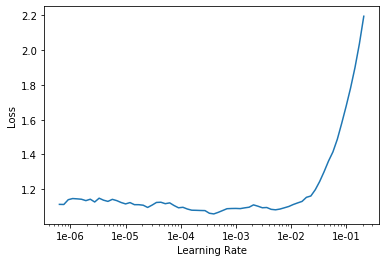

In [33]:
learn.lr_find(wd=0.001)
learn.recorder.plot()

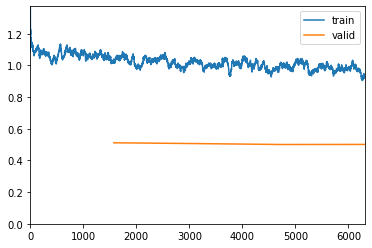

In [34]:
lr=4e-04

learn.fit_one_cycle(4,slice(lr),wd=0.001)

In [35]:
learn.save('food-101-ResNet50-stage6')



In [19]:
data = get_data(512, bs=48)

learn = cnn_learner(data, models.resnet50,
                    metrics=[accuracy, top_k_accuracy], callback_fns=ShowGraph)

In [20]:
learn.load("food-101-ResNet50-stage6")

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

In [21]:
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


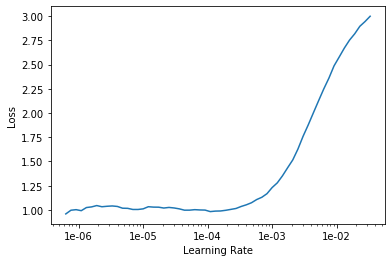

In [23]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


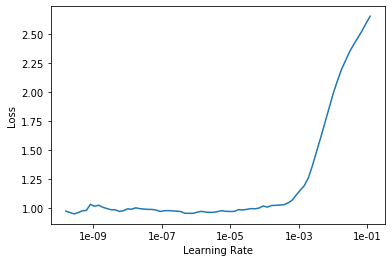

In [24]:
learn.lr_find(start_lr=1e-11,wd=0.9)
learn.recorder.plot()




LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


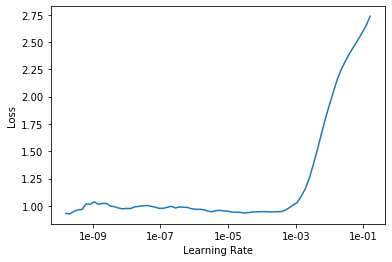

In [25]:
learn.lr_find(start_lr=1e-11,wd=0.5)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


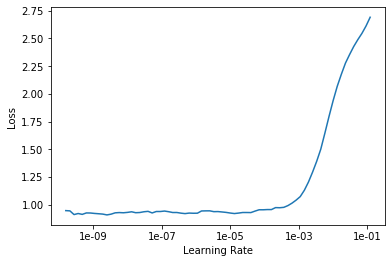

In [26]:
learn.lr_find(start_lr=1e-11,wd=0.1)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


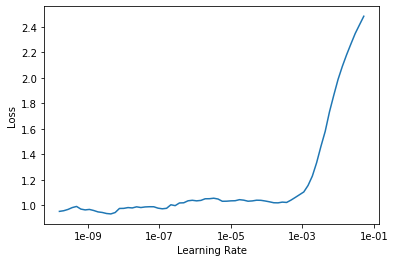

In [27]:
learn.lr_find(start_lr=1e-11,wd=0.01)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


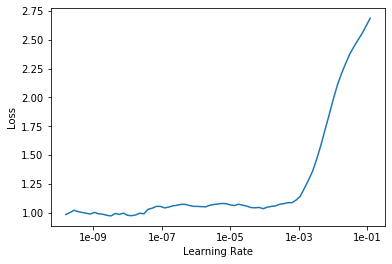

In [28]:
learn.lr_find(start_lr=1e-11,wd=0.05)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


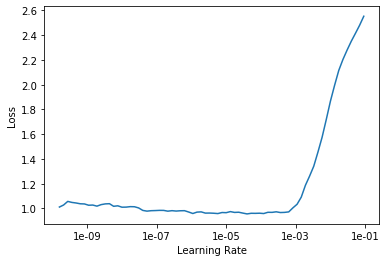

In [29]:
learn.lr_find(start_lr=1e-11,wd=0.001)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


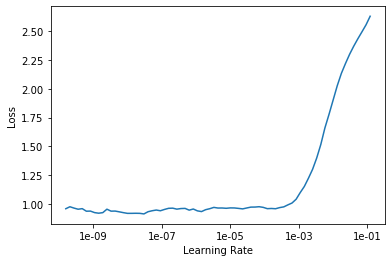

In [30]:
learn.lr_find(start_lr=1e-11,wd=0.005)
learn.recorder.plot()

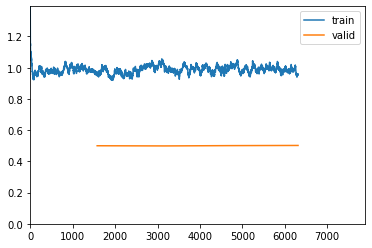

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multi

KeyboardInterrupt: 

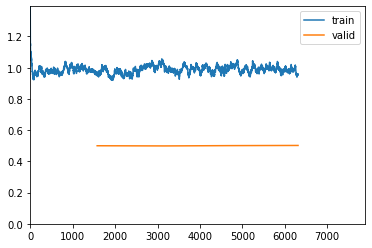

In [31]:

learn.fit_one_cycle(5,slice(1e-09,1e-07,6e-04),wd=0.001)

In [32]:
learn.save('food-101-ResNet50-stage7_final')



In [74]:
learn.purge()

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
data = get_data(512, bs=48)

learn = cnn_learner(data, models.resnet50,
                    metrics=[accuracy, top_k_accuracy], callback_fns=ShowGraph)

In [16]:
learn.load('food-101-ResNet50-stage7_final')



Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

In [17]:
learn.to_fp32()

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

In [26]:
accuracy(*learn.TTA())


tensor(0.8602)

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

In [28]:
interp.confusion_matrix().trace()

21631

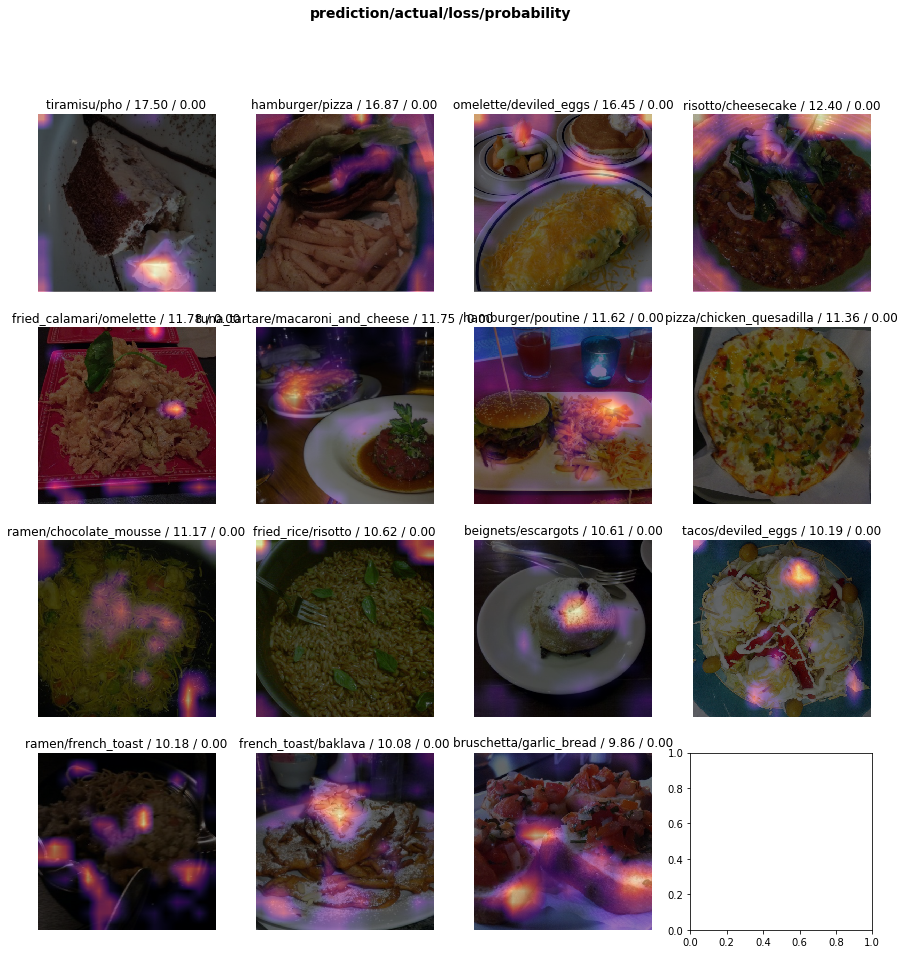

In [29]:
interp.plot_top_losses(15, figsize=(15,15))

In [30]:
interp.most_confused(min_val=2)

[('steak', 'filet_mignon', 49),
 ('filet_mignon', 'steak', 34),
 ('chocolate_cake', 'chocolate_mousse', 32),
 ('pork_chop', 'filet_mignon', 24),
 ('pork_chop', 'grilled_salmon', 22),
 ('tuna_tartare', 'beef_tartare', 22),
 ('apple_pie', 'bread_pudding', 21),
 ('chocolate_mousse', 'chocolate_cake', 20),
 ('prime_rib', 'steak', 20),
 ('beef_tartare', 'tuna_tartare', 19),
 ('steak', 'pork_chop', 19),
 ('steak', 'prime_rib', 19),
 ('pork_chop', 'steak', 17),
 ('dumplings', 'gyoza', 15),
 ('ice_cream', 'frozen_yogurt', 15),
 ('ravioli', 'gnocchi', 15),
 ('filet_mignon', 'prime_rib', 14),
 ('nachos', 'tacos', 14),
 ('ravioli', 'shrimp_and_grits', 14),
 ('spring_rolls', 'samosa', 14),
 ('baby_back_ribs', 'steak', 13),
 ('chicken_quesadilla', 'breakfast_burrito', 13),
 ('clam_chowder', 'lobster_bisque', 12),
 ('falafel', 'crab_cakes', 12),
 ('fried_calamari', 'onion_rings', 12),
 ('baklava', 'apple_pie', 11),
 ('cheesecake', 'strawberry_shortcake', 11),
 ('chocolate_cake', 'red_velvet_cake', 1

In [31]:
data.valid_ds

LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images

In [32]:
25250-21631


3619

In [ ]:
src=(ImageList.from_df(split_list,path/'images',suffix='.jpg')
     .split_from_df(1)
     .label_from_df(cols="label"))

In [18]:
from fastai.widgets import *

In [19]:
db = (ImageList.from_df(split_list,path/'images',suffix='.jpg')
                   .split_none()
                   .label_from_df(cols='label')
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [22]:
learn.data=data

In [23]:
learn_cln=learn.load('food-101-ResNet50-stage7_final')


In [25]:
learn_cln.data=db

In [26]:
learn_cln.to_fp32()

Learner(data=ImageDataBunch;

Train: LabelList (101000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
churros,hot_and_sour_soup,samosa,sashimi,pork_chop
Path: /home/jupyter/.fastai/data/food-101/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/jupyter/.fastai/data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3

In [27]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

101000

In [ ]:
ImageCleaner(ds, idxs,path)




